In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, \
    TimeSeriesResampler
from tslearn.clustering import silhouette_score
import seaborn as sns
from tslearn.utils import to_time_series_dataset
from tslearn.clustering import silhouette_score

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score 
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import KElbowVisualizer

from imblearn.over_sampling import RandomOverSampler
from collections import Counter

import keras
#from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import tensorflow as tf

from imblearn.over_sampling import SMOTE

from mpl_toolkits.mplot3d import Axes3D

# Functions

In [36]:
def load_labels(link, method, abm, k):
    labels_df = pd.read_json(link, lines=True) 
    row = labels_df[(labels_df["method"] == method) &
                    (labels_df["abm"] == abm) &
                    (labels_df["k"] == k)] 
    if not row.empty:
        labels = row.iloc[0]["labels"]
        print(f"Loaded {len(labels)} labels for {method.upper()} ({abm}), k={k}")
    else:
        print("No matching entry found.")
    return labels

In [37]:
def knn_cluster(inputs, labels):
    X_train, X_test, y_train, y_test = train_test_split(inputs, labels, test_size=0.1, random_state = 1)
    knn_clf=KNeighborsClassifier()
    knn_clf.fit(X_train,y_train)
    ypred=knn_clf.predict(X_test)
    result = confusion_matrix(y_test, ypred)
    print("Confusion Matrix:")
    print(result)
    report = classification_report(y_test, ypred)
    print("Report:",)
    print (report)
    acc = accuracy_score(y_test,ypred)
    print("Accuracy:",acc)

In [38]:
def mlp_baseline(inputs, labels, k):
    X_train, X_test, y_train, y_test = train_test_split(inputs, labels, test_size=0.1, random_state = 1)
    X = X_train
    Y = y_train
    dummy_y = to_categorical(Y)
    
    model = Sequential()
    model.add(Dense(8, input_shape=(X.shape[1],), activation='relu'))
    model.add(Dense(7, activation='softmax'))
    model.summary()
    
    model.compile(optimizer='rmsprop', 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
     
    es = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                       mode='min',
                                       patience=10, 
                                       restore_best_weights=True)
    
    history = model.fit(X,
                        dummy_y,
                        callbacks=[es],
                        epochs=500, 
                        batch_size=10,
                        shuffle=True,
                        validation_split=0.2,
                        verbose=1)
    history_dict = history.history
    
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    
    epochs = range(1, len(acc) + 1)
    
    plt.plot(epochs, acc, 'r', label='Training accuracy')
    
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    preds = model.predict(X) 
    print(preds[0]) 
    print(np.sum(preds[0])) 
    
    matrix = confusion_matrix(dummy_y.argmax(axis=1), preds.argmax(axis=1))
    matrix
    print(classification_report(dummy_y.argmax(axis=1), preds.argmax(axis=1)))
    preds = model.predict(X_test) 
    print("Report:",)
    print(classification_report(y_test, preds.argmax(axis=1)))
    acc = accuracy_score(y_test,preds.argmax(axis=1))
    print("Accuracy:",acc)

In [39]:
def mlp_improved(inputs, labels, k):
    X_train_raw, X_val, y_train_raw, y_val = train_test_split(
        inputs, labels, 
        test_size=0.2, 
        stratify=labels,
        random_state=42)
    scaler = StandardScaler()
    X_train_res = scaler.fit_transform(X_train_raw)
    X_val_scaled = scaler.transform(X_val)
    
    num_classes = len(pd.Series(labels).unique())
    y_train_cat = to_categorical(y_train_raw, num_classes)
    y_val_cat   = to_categorical(y_val, num_classes)
    
    num_classes = k
    
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train_res.shape[1],)),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    es = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )
    
    history = model.fit(
        X_train_res,
        y_train_cat,
        validation_data=(X_val_scaled, y_val_cat),
        epochs=200,
        batch_size=512,
        callbacks=[es],
        shuffle=True,
        verbose=1
    )
    
    val_preds = model.predict(X_val_scaled).argmax(axis=1)
    
    print(confusion_matrix(y_val, val_preds))
    print(classification_report(y_val, val_preds, digits=4))
    return X_train_raw, X_val, y_train_raw, y_val, val_preds

In [40]:
def mlp_improved_smote(inputs, labels, k):
    X_train_raw, X_val, y_train_raw, y_val = train_test_split(
        inputs, labels, 
        test_size=0.2, 
        stratify=labels,
        random_state=42)

    sm = SMOTE(k_neighbors=3, random_state=42)
    X_train_res, y_train_res = sm.fit_resample(X_train_raw, y_train_raw)

    scaler = StandardScaler()
    X_train_res = scaler.fit_transform(X_train_res)
    X_val_scaled = scaler.transform(X_val)
    
    
    num_classes = len(pd.Series(labels).unique())
    y_train_cat = to_categorical(y_train_res, num_classes)
    y_val_cat   = to_categorical(y_val, num_classes)
    
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train_res.shape[1],)),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    es = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )
    
    history = model.fit(
        X_train_res,
        y_train_cat,
        validation_data=(X_val_scaled, y_val_cat),
        epochs=200,
        batch_size=512,
        callbacks=[es],
        shuffle=True,
        verbose=1
    )
    
    val_preds = model.predict(X_val_scaled).argmax(axis=1)
    
    print(confusion_matrix(y_val, val_preds))
    print(classification_report(y_val, val_preds, digits=4))
    return X_train_raw, X_val, y_train_raw, y_val, val_preds

# Bank Reserves

In [69]:
br_inputs = pd.read_csv("~/Desktop/TS-Clustering/SimData/bank_reserves_inputs.csv", header=None)
br_inputs_arr = br_inputs.iloc[:, 0].to_numpy()

In [70]:
labels = load_labels("~/Desktop/TS-Clustering/daep_labels_agglom_centroid.ndjson", "daep", "BR", 7)

Loaded 100000 labels for DAEP (BR), k=7


In [71]:
pd.Series(labels).value_counts()

2    43360
3    27768
1    10599
6     5135
5     4659
0     4316
4     4163
Name: count, dtype: int64

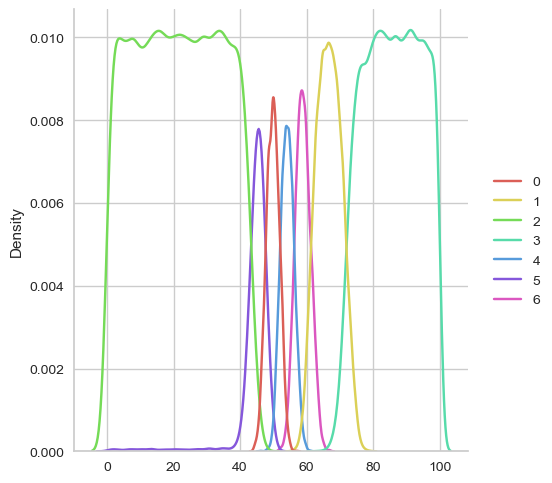

In [72]:
kde_plt = sns.displot(x=br_inputs_arr, hue=labels, kind="kde", palette=sns.color_palette("hls", 7))

In [73]:
knn_cluster(br_inputs, labels)

Confusion Matrix:
[[ 298    0    0    0   69   64    0]
 [   0  881    0   87    1    0   75]
 [   0    0 4264    0    0   62    0]
 [   0   99    0 2735    0    0    0]
 [  68    0    0    0  271    0   77]
 [  49    0   92    0    0  297    0]
 [   2   94    0    0   73    0  342]]
Report:
              precision    recall  f1-score   support

           0       0.71      0.69      0.70       431
           1       0.82      0.84      0.83      1044
           2       0.98      0.99      0.98      4326
           3       0.97      0.97      0.97      2834
           4       0.65      0.65      0.65       416
           5       0.70      0.68      0.69       438
           6       0.69      0.67      0.68       511

    accuracy                           0.91     10000
   macro avg       0.79      0.78      0.79     10000
weighted avg       0.91      0.91      0.91     10000

Accuracy: 0.9088


In [74]:
#mlp_baseline(br_inputs, labels, 7)

In [75]:
X_train_raw, X_val, y_train_raw, y_val, val_preds = mlp_improved(br_inputs, labels, 7)

Epoch 1/200


C:\Users\met48\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7031 - loss: 1.1982 - val_accuracy: 0.7138 - val_loss: 0.5814
Epoch 2/200
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7502 - loss: 0.5338 - val_accuracy: 0.8708 - val_loss: 0.3555
Epoch 3/200
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8723 - loss: 0.3477 - val_accuracy: 0.9114 - val_loss: 0.2669
Epoch 4/200
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8948 - loss: 0.2821 - val_accuracy: 0.9151 - val_loss: 0.2332
Epoch 5/200
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8998 - loss: 0.2549 - val_accuracy: 0.9153 - val_loss: 0.2164
Epoch 6/200
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9050 - loss: 0.2373 - val_accuracy: 0.9157 - val_loss: 0.2088
Epoch 7/200
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9058 - loss: 0.2299 - val_accuracy: 0.9162 - val_loss: 0.2037
Epoch 8/200
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9103 - loss: 0.2217 - val_accuracy: 0.9166

In [76]:
X_train_raw_sm, X_val_sm, y_train_raw_sm, y_val_sm, val_pred_sm = mlp_improved_smote(br_inputs, labels, 7)

Epoch 1/200


C:\Users\met48\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


475/475 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5417 - loss: 1.2105 - val_accuracy: 0.8909 - val_loss: 0.2567
Epoch 2/200
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8050 - loss: 0.4702 - val_accuracy: 0.9024 - val_loss: 0.2384
Epoch 3/200
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8159 - loss: 0.4416 - val_accuracy: 0.9070 - val_loss: 0.2323
Epoch 4/200
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8176 - loss: 0.4328 - val_accuracy: 0.9033 - val_loss: 0.2430
Epoch 5/200
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8200 - loss: 0.4259 - val_accuracy: 0.9064 - val_loss: 0.2358
Epoch 6/200
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8210 - loss: 0.4224 - val_accuracy: 0.9043 - val_loss: 0.2382
Epoch 7/200
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8200 - loss: 0.4234 - val_accuracy: 0.9010 - val_loss: 0.2482
Epoch 8/200
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8206 - loss: 0.4232 - val_accuracy: 0.9069

In [58]:
rf_prob = RandomForestClassifier(random_state=42)
rf_prob.fit(X_val, (val_preds ==  y_val).astype(int))

RandomForestClassifier(random_state=42)

In [59]:
prob_correct = rf_prob.predict_proba(X_val)[:,1]

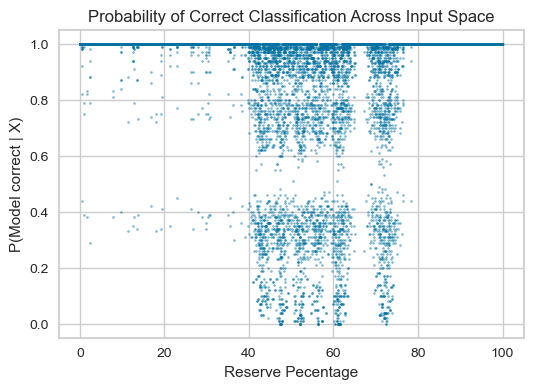

In [60]:
plt.figure(figsize=(6,4))
plt.scatter(
    X_val.iloc[:,0],
    prob_correct,
    alpha = 0.5,
    s = 2
)
plt.xlabel("Reserve Pecentage")
plt.ylabel("P(Model correct | X)")
plt.title("Probability of Correct Classification Across Input Space")
plt.show()

# Epstein Civil Violence

In [80]:
ecv_inputs = pd.read_csv("~/Desktop/TS-Clustering/SimData/epsteinCV_inputs.csv", header=None, sep=' ')
ecv_inputs_arr = ecv_inputs.iloc[:, 0].to_numpy()

In [81]:
labels = load_labels("~/Desktop/TS-Clustering/daep_labels_agglom_centroid.ndjson", "daep", "ECV", 8)

Loaded 50362 labels for DAEP (ECV), k=8


In [82]:
pd.Series(labels).value_counts()

0    42123
4     4692
2     1668
1      677
3      502
5      374
6      254
7       72
Name: count, dtype: int64

In [83]:
knn_cluster(ecv_inputs, labels)

Confusion Matrix:
[[4162    1   35    6    4    0    1    1]
 [   3   25   12    0   35    6    0    0]
 [  48   11   92    1    5    7    0    0]
 [  14    0    0   24    6    0    2    0]
 [   5   17   11    3  426    0    0    0]
 [   2   10   18    0    6    1    0    0]
 [  13    0    1    8    2    0    4    0]
 [   3    0    0    0    6    0    0    0]]
Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      4210
           1       0.39      0.31      0.34        81
           2       0.54      0.56      0.55       164
           3       0.57      0.52      0.55        46
           4       0.87      0.92      0.89       462
           5       0.07      0.03      0.04        37
           6       0.57      0.14      0.23        28
           7       0.00      0.00      0.00         9

    accuracy                           0.94      5037
   macro avg       0.50      0.43      0.45      5037
weighted avg       0.93      0.94

In [84]:
X_train_raw, X_val, y_train_raw, y_val, val_preds = mlp_improved(ecv_inputs, labels, 8)

Epoch 1/200


C:\Users\met48\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4461 - loss: 1.7316 - val_accuracy: 0.8364 - val_loss: 0.5951
Epoch 2/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8524 - loss: 0.5437 - val_accuracy: 0.8830 - val_loss: 0.4352
Epoch 3/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8847 - loss: 0.4253 - val_accuracy: 0.9030 - val_loss: 0.3567
Epoch 4/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8984 - loss: 0.3549 - val_accuracy: 0.9153 - val_loss: 0.2977
Epoch 5/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9092 - loss: 0.3021 - val_accuracy: 0.9278 - val_loss: 0.2563
Epoch 6/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9214 - loss: 0.2577 - val_accuracy: 0.9322 - val_loss: 0.2255
Epoch 7/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9250 - loss: 0.2350 - val_accuracy: 0.9359 - val_loss: 0.2036
Epoch 8/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9294 - loss: 0.2186 - val_accuracy: 0.9418 - val_loss: 0.1

C:\Users\met48\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\met48\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\met48\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

In [85]:
X_train_raw_sm, X_val_sm, y_train_raw_sm, y_val_sm, val_pred_sm = mlp_improved_smote(ecv_inputs, labels, 8)

Epoch 1/200


C:\Users\met48\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


527/527 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4597 - loss: 1.3764 - val_accuracy: 0.8975 - val_loss: 0.2573
Epoch 2/200
527/527 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7503 - loss: 0.6442 - val_accuracy: 0.9128 - val_loss: 0.2353
Epoch 3/200
527/527 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7699 - loss: 0.5940 - val_accuracy: 0.9177 - val_loss: 0.2286
Epoch 4/200
527/527 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7757 - loss: 0.5740 - val_accuracy: 0.9192 - val_loss: 0.2320
Epoch 5/200
527/527 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7809 - loss: 0.5628 - val_accuracy: 0.9201 - val_loss: 0.2272
Epoch 6/200
527/527 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7830 - loss: 0.5515 - val_accuracy: 0.9221 - val_loss: 0.2247
Epoch 7/200
527/527 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7846 - loss: 0.5476 - val_accuracy: 0.9205 - val_loss: 0.2318
Epoch 8/200
527/527 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7868 - loss: 0.5411 - val_accuracy: 0.9201

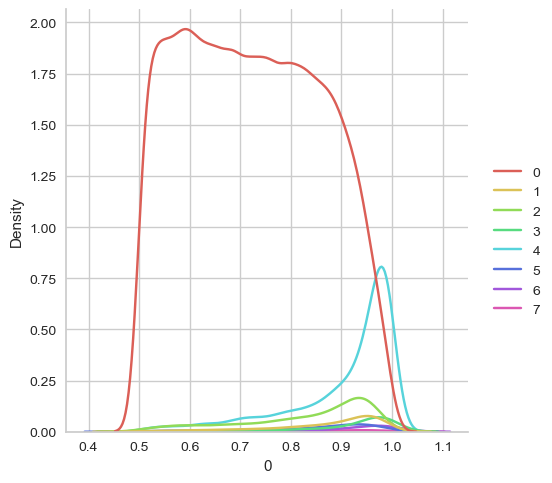

In [86]:
plt_kde = sns.displot(x=ecv_inputs[0], hue=labels, kind="kde", palette=sns.color_palette("hls", 8))

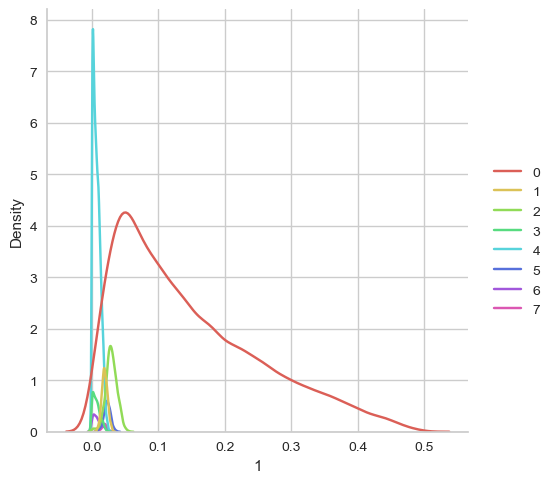

In [87]:
plt_kde = sns.displot(x=ecv_inputs[1], hue=labels, kind="kde", palette=sns.color_palette("hls", 8))

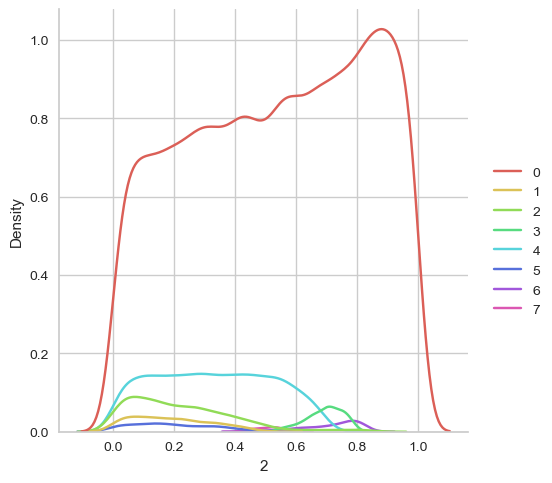

In [88]:
plt_kde = sns.displot(x=ecv_inputs[2], hue=labels, kind="kde", palette=sns.color_palette("hls", 8))

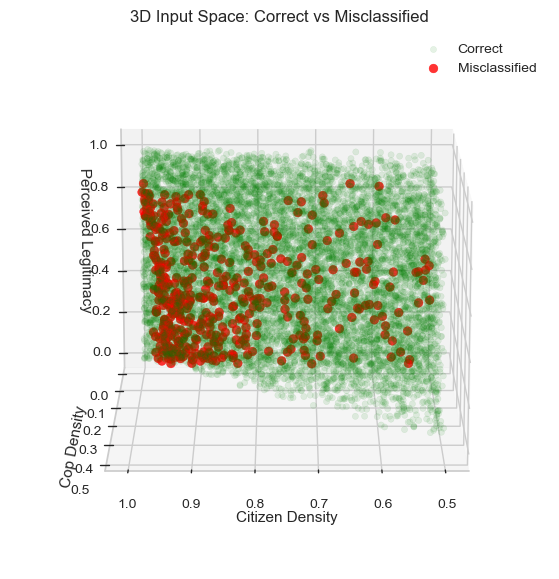

In [89]:
# --- Identify misclassifications ---
correct = (val_preds == y_val)
incorrect = ~correct

# --- Extract correct & incorrect points ---
Xc = X_val.to_numpy()[correct]
Xi = X_val.to_numpy()[incorrect]

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

# plot correct classifications
ax.scatter(Xc[:,0], Xc[:,1], Xc[:,2], 
           c='green', s=20, alpha=0.1, label='Correct')

# plot misclassifications
ax.scatter(Xi[:,0], Xi[:,1], Xi[:,2], 
           c='red', s=40, alpha=0.8, label='Misclassified')

ax.set_xlabel("Citizen Density")
ax.set_ylabel("Cop Density")
ax.set_zlabel("Perceived Legitimacy")
ax.set_title("3D Input Space: Correct vs Misclassified")

ax.legend()
ax.view_init(elev=15, azim=90)

plt.show()

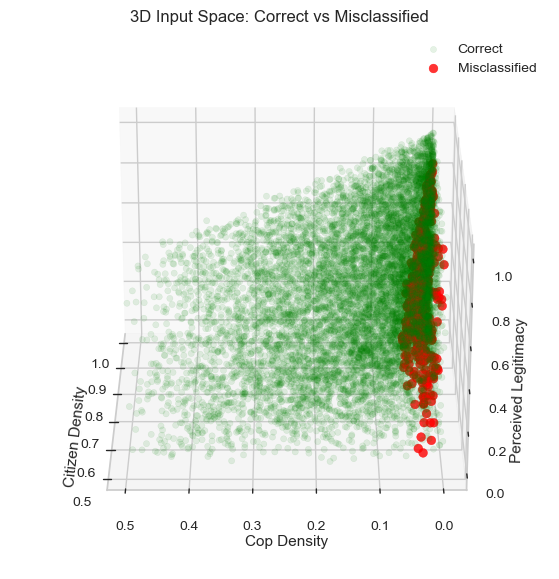

In [90]:
# --- Identify misclassifications ---
correct = (val_preds == y_val)
incorrect = ~correct

# --- Extract correct & incorrect points ---
Xc = X_val.to_numpy()[correct]
Xi = X_val.to_numpy()[incorrect]

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

# plot correct classifications
ax.scatter(Xc[:,0], Xc[:,1], Xc[:,2], 
           c='green', s=20, alpha=0.1, label='Correct')

# plot misclassifications
ax.scatter(Xi[:,0], Xi[:,1], Xi[:,2], 
           c='red', s=40, alpha=0.8, label='Misclassified')

ax.set_xlabel("Citizen Density")
ax.set_ylabel("Cop Density")
ax.set_zlabel("Perceived Legitimacy")
ax.set_title("3D Input Space: Correct vs Misclassified")

ax.legend()
ax.view_init(elev=25, azim=180)

plt.show()

In [92]:
rf_prob = RandomForestClassifier(random_state=42)
rf_prob.fit(X_val, (val_pred_sm ==  y_val_sm).astype(int))

RandomForestClassifier(random_state=42)

In [93]:
prob_correct = rf_prob.predict_proba(X_val)[:,1]

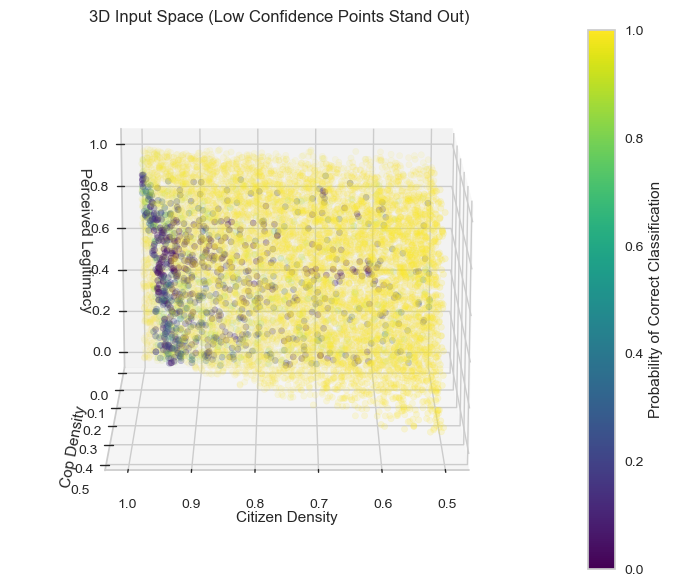

In [98]:
X_arr = X_val.to_numpy()
pc = prob_correct  # array of shape (n,)

# --- Invert the transparency mapping ---
# low prob_correct → alpha near 1
# high prob_correct → alpha near 0.1
alpha = 0.2 + 0.8 * (1 - (pc - pc.min()) / (pc.max() - pc.min()))

# --- Map prob_correct to a colormap (color still encoded normally) ---
cmap = plt.get_cmap("viridis")
colors = cmap(pc)        # Nx4 RGBA
colors[:, 3] = alpha     # replace only the alpha channel

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

p = ax.scatter(
    X_arr[:,0], X_arr[:,1], X_arr[:,2],
    color=colors,
    s=20
)

ax.set_xlabel("Citizen Density")
ax.set_ylabel("Cop Density")
ax.set_zlabel("Perceived Legitimacy")
ax.set_title("3D Input Space (Low Confidence Points Stand Out)")

# colorbar for prob_correct (alpha ignored)
cb = fig.colorbar(plt.cm.ScalarMappable(cmap=cmap), ax=ax)
cb.set_label("Probability of Correct Classification")

ax.view_init(elev=15, azim=90)

plt.show()

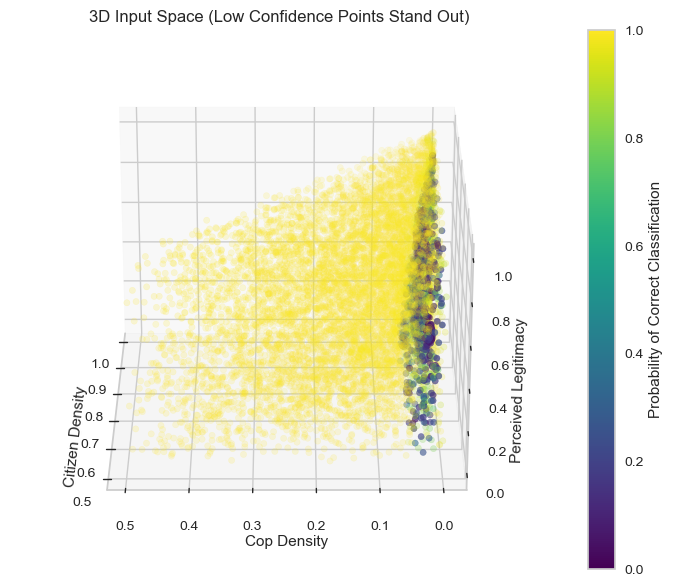

In [99]:
X_arr = X_val.to_numpy()
pc = prob_correct  # array of shape (n,)

# --- Invert the transparency mapping ---
# low prob_correct → alpha near 1
# high prob_correct → alpha near 0.1
alpha = 0.2 + 0.8 * (1 - (pc - pc.min()) / (pc.max() - pc.min()))

# --- Map prob_correct to a colormap (color still encoded normally) ---
cmap = plt.get_cmap("viridis")
colors = cmap(pc)        # Nx4 RGBA
colors[:, 3] = alpha     # replace only the alpha channel

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

p = ax.scatter(
    X_arr[:,0], X_arr[:,1], X_arr[:,2],
    color=colors,
    s=20
)

ax.set_xlabel("Citizen Density")
ax.set_ylabel("Cop Density")
ax.set_zlabel("Perceived Legitimacy")
ax.set_title("3D Input Space (Low Confidence Points Stand Out)")

# colorbar for prob_correct (alpha ignored)
cb = fig.colorbar(plt.cm.ScalarMappable(cmap=cmap), ax=ax)
cb.set_label("Probability of Correct Classification")

ax.view_init(elev=25, azim=180)

plt.show()

# Forest Fire

In [100]:
ff_inputs = pd.read_csv("~/Desktop/TS-Clustering/SimData/forest_fire_inputs.csv", header=None, sep=' ')
ff_inputs_arr = ff_inputs.iloc[:, 0].to_numpy()

In [93]:
labels_df = pd.read_json("~/Desktop/TS-Clustering/daep_labels_agglom_centroid.ndjson", lines=True)
method = "daep"      
abm = "FF"          
k = 4                #

row = labels_df[(labels_df["method"] == method) &
                (labels_df["abm"] == abm) &
                (labels_df["k"] == k)]

if not row.empty:
    labels = row.iloc[0]["labels"]
    print(f"Loaded {len(labels)} labels for {method.upper()} ({abm}), k={k}")
else:
    print("No matching entry found.")

Loaded 100000 labels for DAEP (FF), k=4


In [94]:
pd.Series(labels).value_counts()

1    58446
0    40415
2      724
3      415
Name: count, dtype: int64

In [95]:
X_train, X_test, y_train, y_test = train_test_split(ff_inputs, labels, test_size=0.1, random_state = 1)
knn_clf=KNeighborsClassifier()
knn_clf.fit(X_train,y_train)
ypred=knn_clf.predict(X_test)

In [96]:
result = confusion_matrix(y_test, ypred)
print("Confusion Matrix:")
print(result)
report = classification_report(y_test, ypred)
print("Report:",)
print (report)
acc = accuracy_score(y_test,ypred)
print("Accuracy:",acc)

Confusion Matrix:
[[4041   37   16    3]
 [  32 5745    2    1]
 [  52   15    4    2]
 [  24   24    2    0]]
Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      4097
           1       0.99      0.99      0.99      5780
           2       0.17      0.05      0.08        73
           3       0.00      0.00      0.00        50

    accuracy                           0.98     10000
   macro avg       0.53      0.51      0.51     10000
weighted avg       0.97      0.98      0.97     10000

Accuracy: 0.979


In [97]:
X_train_raw, X_val, y_train_raw, y_val = train_test_split(
    ff_inputs, labels,
    test_size=0.2,
    stratify = labels,
    random_state=42)

In [98]:
sm = SMOTE(k_neighbors=3, random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_raw, y_train_raw)

In [99]:
pd.Series(y_train_res).value_counts()

1    46757
0    46757
2    46757
3    46757
Name: count, dtype: int64

In [100]:
scaler = StandardScaler()
X_train_res = scaler.fit_transform(X_train_res)
X_val_scaled = scaler.transform(X_val)

In [101]:
num_classes = len(pd.Series(labels).unique())
y_train_cat = to_categorical(y_train_res, num_classes)
y_val_cat   = to_categorical(y_val, num_classes)

In [102]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_res.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    X_train_res,
    y_train_cat,
    validation_data=(X_val_scaled, y_val_cat),
    epochs=200,
    batch_size=512,
    callbacks=[es],
    shuffle=True,
    verbose=1
)

Epoch 1/200


C:\Users\met48\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


366/366 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6332 - loss: 0.8689 - val_accuracy: 0.9370 - val_loss: 0.1793
Epoch 2/200
366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7641 - loss: 0.4637 - val_accuracy: 0.9444 - val_loss: 0.1754
Epoch 3/200
366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7669 - loss: 0.4575 - val_accuracy: 0.9466 - val_loss: 0.1736
Epoch 4/200
366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7680 - loss: 0.4560 - val_accuracy: 0.9445 - val_loss: 0.1837
Epoch 5/200
366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7676 - loss: 0.4533 - val_accuracy: 0.9452 - val_loss: 0.1784
Epoch 6/200
366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7683 - loss: 0.4529 - val_accuracy: 0.9463 - val_loss: 0.1716
Epoch 7/200
366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7691 - loss: 0.4489 - val_accuracy: 0.9448 - val_loss: 0.1787
Epoch 8/200
366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7704 - loss: 0.4489 - val_accuracy: 0.9452

In [103]:
val_preds = model.predict(X_val_scaled).argmax(axis=1)

print(confusion_matrix(y_val, val_preds))
print(classification_report(y_val, val_preds, digits=4))

625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 594us/step
[[ 7531     0   419   133]
 [    4 11266    45   374]
 [    1     1    72    71]
 [    0     0    19    64]]
              precision    recall  f1-score   support

           0     0.9993    0.9317    0.9643      8083
           1     0.9999    0.9638    0.9815     11689
           2     0.1297    0.4966    0.2057       145
           3     0.0997    0.7711    0.1766        83

    accuracy                         0.9466     20000
   macro avg     0.5572    0.7908    0.5820     20000
weighted avg     0.9896    0.9466    0.9656     20000



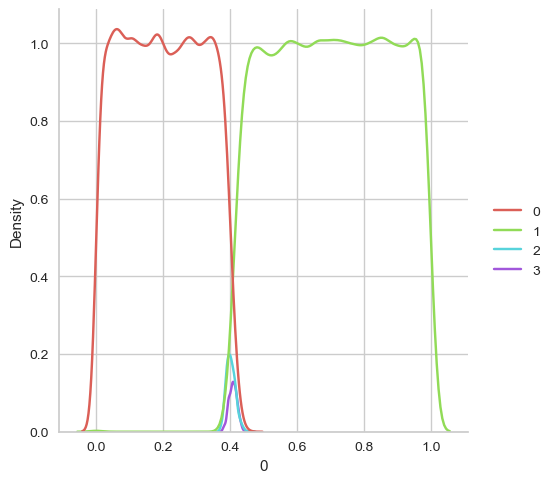

In [104]:
plt = sns.displot(x=ff_inputs[0], hue=labels, kind="kde", palette=sns.color_palette("hls", 4))

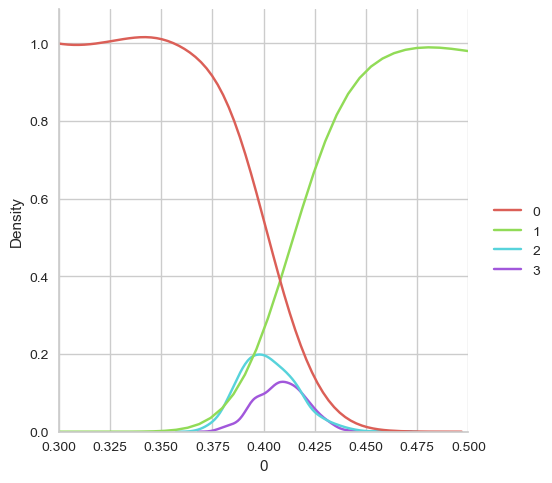

In [105]:
plt = sns.displot(x=ff_inputs[0], hue=labels, kind="kde", palette=sns.color_palette("hls", 4))
plt.set(xlim=(0.3, 0.5))

In [106]:
y_pred = preds.argmax(axis=1)
correct = (y_pred == y_test)
correct_binary = correct.astype(int)

In [112]:
model.predict(X_train)

2813/2813 ━━━━━━━━━━━━━━━━━━━━ 2s 560us/step


array([[2.35179486e-03, 8.04768384e-01, 1.41035780e-01, 5.18440716e-02],
       [7.88431123e-07, 9.99895096e-01, 9.82303609e-05, 5.83892279e-06],
       [1.15406476e-10, 1.00000000e+00, 3.77401008e-08, 3.10531351e-10],
       ...,
       [3.16877248e-13, 1.00000000e+00, 2.20194626e-10, 5.13607277e-13],
       [5.52150514e-03, 5.20135641e-01, 3.03384721e-01, 1.70958161e-01],
       [6.43086992e-07, 9.99912977e-01, 8.17369291e-05, 4.65009498e-06]],
      dtype=float32)

In [114]:
rf_prob = RandomForestClassifier(random_state=42)
rf_prob.fit(X_train, (model.predict(scaler.transform(X_train)).argmax(axis=1) == y_train).astype(int))

2813/2813 ━━━━━━━━━━━━━━━━━━━━ 2s 582us/step


RandomForestClassifier(random_state=42)

In [115]:
prob_correct = rf_prob.predict_proba(X_test)[:,1]

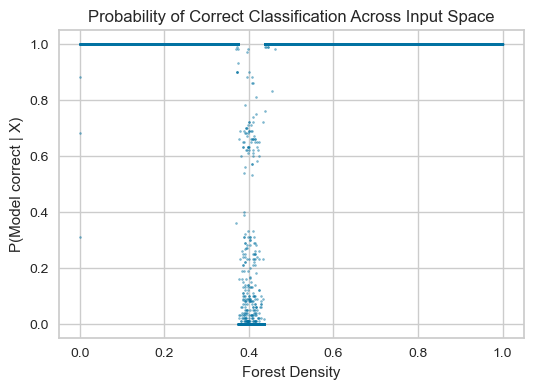

In [116]:
plt.figure(figsize=(6,4))
plt.scatter(
    X_test.iloc[:,0],
    prob_correct,
    alpha = 0.5,
    s = 2
)
plt.xlabel("Forest Density")
plt.ylabel("P(Model correct | X)")
plt.title("Probability of Correct Classification Across Input Space")
plt.show()